# Identify Fraud from Enron Email

## 1 Introduction

In this report, I will use machine learning to build a person of interest (POI) identifier based on Enron financial and email data made public as a result of the Enron scandal.

I will start by exploring the data set and investigating outliers. Then I will build the POI identifier following the process of feature selection/engineering, algorithm picking/tuning, validation, evaluation.

In [51]:
import pickle
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
# Change figure size into 8 by 6 inches
matplotlib.rcParams['figure.figsize'] = (8, 6)

Populating the interactive namespace from numpy and matplotlib


## 2 Data Exploration 
**Related mini-project: Lesson 5**

Q: Student response addresses the most important characteristics of the dataset and uses these characteristics to inform their analysis. Important characteristics include:
- total number of data points
- allocation across classes (POI/non-POI)
- number of features
- are there features with many missing values? etc.

A: There are 146 data points in the dataset.

Out of the 146 data points, there are 18 of them are identified as POIs, and the rest 128 are non-POIs.

Each data point consists the name of the person and 21 features (1 POI flag, 14 financial features and 6 email features). All financial features have real number values, and all email features except email_address feature (string value) have integer values.

All features have missing values (tabulated below). I notice there is a large difference in terms of percentages of missing values between POIs and non_POIs. By imputing the missing values with 0, I get to preserve this distinction. In other words, after imputing, a value of 0 gives different probability of being a POI than being a non-POI.

In [25]:
# Load the dataset
with open('final_project_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)

In [26]:
# Total number of data points
print('There are {} people in the dataset.'.format(len(data_dict)))

There are 146 people in the dataset.


In [27]:
# Allocation across classes (POI/non-POI)
poi_counts = defaultdict(int)
for features_values in data_dict.values():
    poi_counts[features_values['poi']] += 1
print('There are {} POIs and {} non-POIs.'.format(poi_counts[True], poi_counts[False]))

There are 18 POIs and 128 non-POIs.


In [28]:
# Number of features
print('There are {} features.'.format(len(list(data_dict.values())[0])))
# Names of features
list(list(data_dict.values())[0].keys())

There are 21 features.


['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'email_address',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'director_fees']

In [38]:
# Features with missing values
nan_counts_poi = defaultdict(int)
nan_counts_non_poi = defaultdict(int)
for data_point in data_dict.values():
    if data_point['poi'] == True:
        for feature, value in data_point.items():
            if value == "NaN":
                nan_counts_poi[feature] += 1
    elif data_point['poi'] == False:
        for feature, value in data_point.items():
            if value == "NaN":
                nan_counts_non_poi[feature] += 1
    else:
        print('Got an uncategorized person.')
nan_counts_df = pd.DataFrame([nan_counts_poi, nan_counts_non_poi]).T
nan_counts_df = nan_counts_df.fillna(value=0)
nan_counts_df.columns = ['# NaN in POIs', '# NaN in non-POIs']
nan_counts_df['# NaN total'] = nan_counts_df['# NaN in POIs'] + \
                               nan_counts_df['# NaN in non-POIs']
nan_counts_df['% NaN in POIs'] = nan_counts_df['# NaN in POIs'] / \
                                          poi_counts[True] * 100
nan_counts_df['% NaN in non-POIs'] = nan_counts_df['# NaN in non-POIs'] / \
                                          poi_counts[False] * 100
nan_counts_df['% NaN total'] = nan_counts_df['# NaN total'] / \
                                          len(data_dict) * 100
    
nan_counts_df

,# NaN in POIs,# NaN in non-POIs,# NaN total,% NaN in POIs,% NaN in non-POIs,% NaN total
bonus,2.0,62.0,64.0,11.111111,48.43750,43.835616
deferral_payments,13.0,94.0,107.0,72.222222,73.43750,73.287671
deferred_income,7.0,90.0,97.0,38.888889,70.31250,66.438356
director_fees,18.0,111.0,129.0,100.000000,86.71875,88.356164
email_address,0.0,35.0,35.0,0.000000,27.34375,23.972603
exercised_stock_options,6.0,38.0,44.0,33.333333,29.68750,30.136986
expenses,0.0,51.0,51.0,0.000000,39.84375,34.931507
from_messages,4.0,56.0,60.0,22.222222,43.75000,41.095890
from_poi_to_this_person,4.0,56.0,60.0,22.222222,43.75000,41.095890
from_this_person_to_poi,4.0,56.0,60.0,22.222222,43.75000,41.095890


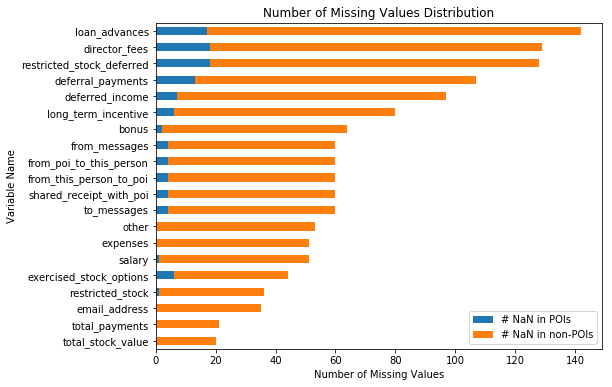

In [53]:
# Plot missing values distribution
ax = nan_counts_df.sort_values('# NaN total')[['# NaN in POIs', '# NaN in non-POIs']].plot(kind='barh', 
                                                                                    stacked=True)
ax.set_title('Number of Missing Values Distribution')
ax.set_xlabel('Number of Missing Values')
ax.set_ylabel('Variable Name')


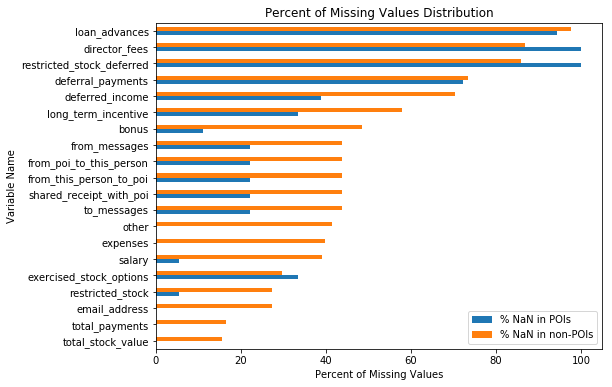

In [54]:
# Plot missing values distribution
ax = nan_counts_df.sort_values('# NaN total')[['% NaN in POIs', '% NaN in non-POIs']].plot(kind='barh', 
                                                                                    stacked=False)
ax.set_title('Percent of Missing Values Distribution')
ax.set_xlabel('Percent of Missing Values')
ax.set_ylabel('Variable Name')